# 데이터 불러오기

---
- 네이버 영화 리뷰 데이터를 이용해 한글 감정 분석을 진행.
- 데이터 출처: https://github.com/e9t/nsmc

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 파일 사이즈 확인
WORKING_DIRECTORY = "./"
print("파일 크기: ")
for file in os.listdir(WORKING_DIRECTORY):
    if "txt" in file:
        print(file.ljust(30) + str(round(os.path.getsize(WORKING_DIRECTORY + file) / 1000000, 2)) + "MB")

파일 크기: 
korean_reviews_train.txt      84.0MB
ratings_test.txt              4.89MB
ratings.txt                   19.52MB
불용어사전.txt                     0.0MB
ratings_train.txt             14.63MB
korean_reviews_test.txt       28.2MB


In [3]:
# 학습 데이터
train_data = pd.read_csv(WORKING_DIRECTORY + "ratings_train.txt", header=0, delimiter="\t", quoting=3)

print(train_data.shape)
train_data.head()

(150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
# 테스트 데이터
test_data = pd.read_csv(WORKING_DIRECTORY + "ratings_test.txt", header=0, delimiter="\t", quoting=3)

print(test_data.shape)
test_data.head()

(50000, 3)


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


- 학습 데이터와 테스트 데이터가 3:1의 비율로 나눠져 있습니다. (15만 vs 5만)

# EDA

- 학습 데이터의 리뷰들을 바탕으로 여러가지 정보를 뽑아내봅시다.

## 라벨의 분포

0    75173
1    74827
Name: label, dtype: int64


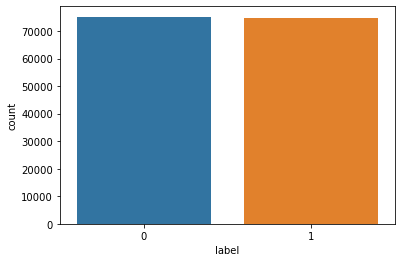

In [5]:
# 학습 데이터의 라벨 분포
print(train_data.label.value_counts())
sns.countplot(train_data.label)
plt.show()

1    25173
0    24827
Name: label, dtype: int64


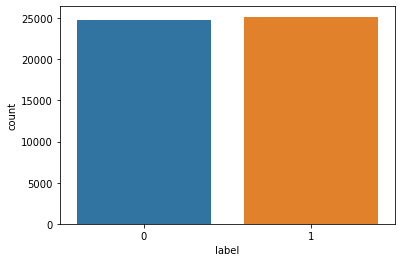

In [6]:
# 테스트 데이터의 라벨 분포
print(test_data.label.value_counts())
sns.countplot(test_data.label)
plt.show()

- 학습/테스트 데이터 모두 라벨이 거의 균등하게 나뉜 것을 확인할 수 있다.

## 리뷰의 글자수 분포

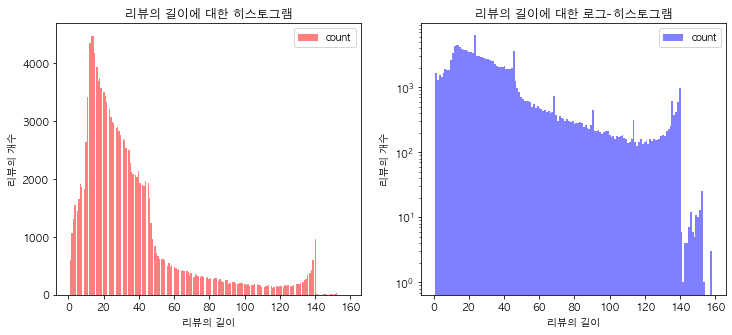

In [7]:
# 리뷰의 글자 수 집계
train_length = train_data.document.astype(str).apply(len)

# 시각화
plt.figure(figsize=(12,5))
plt.rcParams['font.family'] = 'AppleGothic'   # 한글 깨짐 방지

# 히스토그램
plt.subplot(1,2,1)
train_length.plot(kind="hist", bins=200, alpha=0.5, color="red", label="count")
plt.legend()
plt.xlabel("리뷰의 길이")
plt.ylabel("리뷰의 개수")
plt.title("리뷰의 길이에 대한 히스토그램")


# 로그 히스토그램
plt.subplot(1,2,2)
train_length.plot(kind="hist", bins=150, alpha=0.5, color="blue", label="count")
plt.yscale("log", nonposy="clip")
plt.legend()
plt.xlabel("리뷰의 길이")
plt.ylabel("리뷰의 개수")
plt.title("리뷰의 길이에 대한 로그-히스토그램")

plt.show()

- 전체적으로 고르게 분포되어 있는 것 같다.
- 20자가 넘어가면서부터 개수가 줄지만, 특이하게 140자 근처에서 다시 값이 상승함.
- 해당 데이터의 경우 글자수가 140자로 제한되어 있기 때문에 (특수문자 제외) 그런 것으로 파악됨.

In [8]:
# 리뷰 길이에 대한 기술 통계량
train_length.describe()

count    150000.000000
mean         35.237493
std          29.582361
min           1.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         158.000000
Name: document, dtype: float64

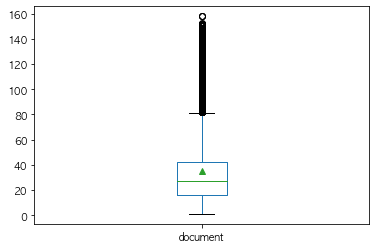

In [9]:
train_length.plot(kind="box", showmeans=True)
plt.show()

- 일부 길이가 긴 데이터들이 존재한다. 길이가 80자 이상인 리뷰들의 특징은 없을지 파악해보자.

In [10]:
# 길이가 긴 리뷰들
long_review_index = train_length[train_length > 80].index
long_reviews = train_data.loc[long_review_index, :]

long_reviews

,id,document,label
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
22,9705777,재미없다 지루하고. 같은 음식 영화인데도 바베트의 만찬하고 넘 차이남....바베트의...,0
44,8548510,윤제문이라는 멋진 배우를 발견하게 됐어요. 소소한 일탈이 잔잔한 미소를 머금게 합니...,1
46,9440670,리얼리티가 뛰어나긴 한데 큰 공감은 안간다. 이민기캐릭터는 정신의학상 분노조절장애 ...,0
49,9837767,"데너리스 타르 가르엔...나도 용의주인이 되고 싶다...누이랑,근친상간이나 하고 다...",1
...,...,...,...
149964,8970481,성룡의진중하고 무게있는 연기가 참좋다. 신주쿠-대병소장-베스트키드-스파이넥스트도어-...,1
149976,9811006,일본은 한국전쟁에 참전한적도 없고 2차세계대전이후 완전 패망했다가 한국전쟁 때 군수...,0
149978,6798178,그리 만족스럽진못했어도 7점은 나와야되는것같아 10점줌. 주인공들연기도 훌륭했고 내...,1
149981,9633559,시간이 아깝다. 어린 여주의 연기는 인상적이었고 나중이 기대되어서 좋았고 남주 여주...,0


0    7165
1    6218
Name: label, dtype: int64


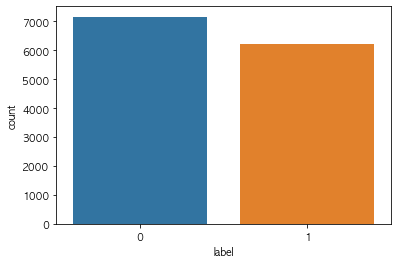

In [11]:
print(long_reviews.label.value_counts())
sns.countplot(long_reviews.label)
plt.show()

- 전체적으로는 라벨이 균등했던 것과 비교해 길이가 길어질 수록 부정적인 리뷰가 좀 더 많은 것을 확인할 수 있다.

## 리뷰의 단어수 분포

In [12]:
train_word_counts = train_data.document.astype(str).apply(lambda x: len(x.split()))

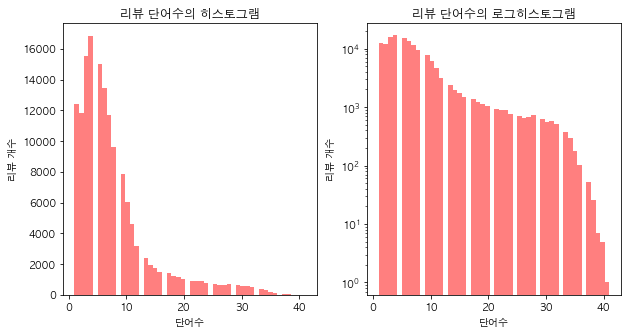

In [13]:
plt.figure(figsize=(10,5))
plt.rcParams['font.family'] = 'AppleGothic'   # 한글 깨짐 방지

# 히스토그램
plt.subplot(1,2,1)
plt.hist(train_word_counts, bins=50, facecolor="red", alpha=0.5, label="word_count")
plt.title("리뷰 단어수의 히스토그램")
plt.xlabel("단어수")
plt.ylabel("리뷰 개수")


# 로그히스토그램
plt.subplot(1,2,2)
plt.hist(train_word_counts, bins=50, facecolor="red", alpha=0.5, label="word_count")
plt.yscale("log", nonposy="clip")
plt.title("리뷰 단어수의 로그히스토그램")
plt.xlabel("단어수")
plt.ylabel("리뷰 개수")

plt.show()

- 대부분의 리뷰들이 10개 미만으로 분포되어 있다.

In [14]:
train_word_counts.describe()

count    150000.000000
mean          7.584940
std           6.514063
min           1.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          41.000000
Name: document, dtype: float64

## 특수문자가 포함된 리뷰 파악

---

- 물음표, 느낌표가 사용된 리뷰의 개수를 파악해보자

In [15]:
print("물음표가 포함된 리뷰: {:.2f} %".format(np.mean(train_data.document.astype(str).apply(lambda x: "?" in x)) * 100))
print("느낌표가 포함된 리뷰: {:.2f} %".format(np.mean(train_data.document.astype(str).apply(lambda x: "!" in x)) * 100))
print("마침표가 포함된 리뷰: {:.2f} %".format(np.mean(train_data.document.astype(str).apply(lambda x: "." in x)) * 100))

물음표가 포함된 리뷰: 8.25 %
느낌표가 포함된 리뷰: 9.38 %
마침표가 포함된 리뷰: 51.76 %


## 띄어쓰기가 안된 리뷰 파악

띄어쓰기가 안된 리뷰: 8.25 %
띄어쓰기가 안된 리뷰: 12381.00 개


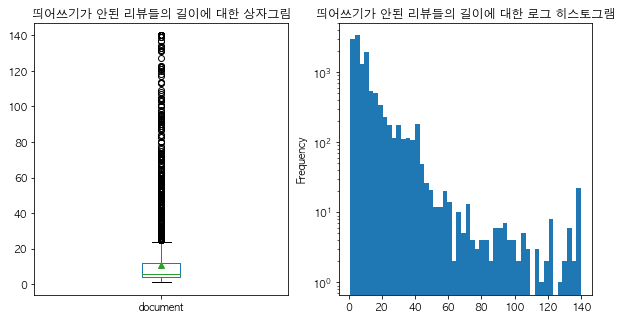

In [16]:
print("띄어쓰기가 안된 리뷰: {:.2f} %".format(np.mean(train_data.document.astype(str).apply(lambda x: " " not in x)) * 100))
print("띄어쓰기가 안된 리뷰: {:.2f} 개".format(np.sum(train_data.document.astype(str).apply(lambda x: " " not in x))))

no_spacing_reviews = train_data.document[train_data.document.astype(str).apply(lambda x: " " not in x)]


# 박스플롯
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
no_spacing_reviews.astype(str).apply(len).plot(kind="box", showmeans=True)
plt.title("띄어쓰기가 안된 리뷰들의 길이에 대한 상자그림")

# 로그 히스토그램
plt.subplot(1,2,2)
no_spacing_reviews.astype(str).apply(len).plot(kind="hist", bins=50)
plt.yscale("log", nonposy="clip")
plt.title("띄어쓰기가 안된 리뷰들의 길이에 대한 로그 히스토그램")
plt.show()

In [17]:
no_spacing_reviews

2         너무재밓었다그래서보는것을추천한다
10         걍인피니트가짱이다.진짜짱이다♥
28                     재밋는뎅
54                    재미있어요
56                       최고
                ...        
149919                    짱
149960                 지루하다
149961                 짠하다~
149966                    1
149987              재미있어요^^
Name: document, Length: 12381, dtype: object

- 약 8.25%의 리뷰들에서 띄어쓰기가 제대로 지켜지지 않았음을 알 수 있다.
- 뒤에 사용할 형태소 분석기는 띄어쓰기를 기준으로 단어들을 분류하기 때문에 띄어쓰기가 제대로 지켜지지 않으면 학습이 제대로 이뤄지지 않을 우려가 있다.

## 리뷰 단어 빈도수 분석

---

- 워드클라우드 사용
- 워드클라우드를 그리기 위해, 문자열이 아닌 데이터는 전부 삭제한다.

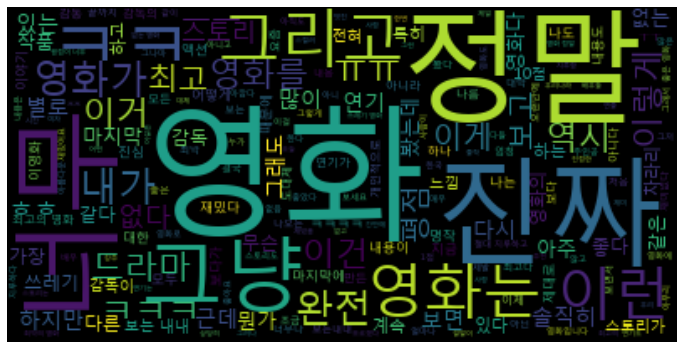

In [18]:
from wordcloud import WordCloud

# 문자열인 데이터만 집계
train_review = [review for review in train_data.document if type(review) is str]

# 워드클라우드 객체 생성
wordcloud = WordCloud(font_path=WORKING_DIRECTORY + "malgun.ttf").generate(" ".join(train_review))

# 시각화
plt.figure(figsize=(12,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

- 너무, 정말, 진짜, 영화 등의 단어가 많이 사용된 것을 알 수 있다.
- ㅋㅋ, ㅎㅎ 등 불용어에 대한 처리가 필요할 것 같다.

# 전처리
- 앞서 EDA를 통해 얻을 정보들을 바탕으로 데이터를 전처리를 진행해 보자.

In [19]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 특수문자 처리

---

- 정규표현식을 이용해 사용되지 않는 특수문자들을 제거해준다.

In [20]:
train_data.document[0]

'아 더빙.. 진짜 짜증나네요 목소리'

In [21]:
import re

# 마침표, 느낌표, 물음표 등을 띄어쓰기 한칸으로 대체
review_text = [re.sub("[\.!?]+", " ", str(review)) for review in train_data.document]

# 한글, 숫자 제외하고 전부 제거
review_text = [re.sub("[^[가-힣\d]+", " ", str(review)) for review in review_text ]

In [22]:
review_text[:10]

['아 더빙 진짜 짜증나네요 목소리',
 '흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 솔직히 재미는 없다 평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
 '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화 별반개도 아까움 ',
 '원작의 긴장감을 제대로 살려내지못했다 ',
 '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지 정말 발로해도 그것보단 낫겟다 납치 감금만반복반복 이드라마는 가족도없다 연기못하는사람만모엿네',
 '액션이 없는데도 재미 있는 몇안되는 영화',
 '왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나 ']

In [23]:
# 테스트 데이터에도 마찬가지로 적용

# 마침표, 느낌표, 물음표 등을 띄어쓰기 한칸으로 대체
review_text_test = [re.sub("[\.!?]+", " ", str(review)) for review in test_data.document]

# 한글, 숫자 제외하고 전부 제거
review_text_test = [re.sub("[^[가-힣\d]+", " ", str(review)) for review in review_text_test]

np.save(open("./korean_reviews_test.txt", "wb"), review_text_test)

## 띄어쓰기, 맞춤법 교정

---

앞서 EDA 과정에서 띄어쓰기와 맞춤법이 제대로 지켜지지 않은 데이터들이 꽤 있는 것을 확인할 수 있었다. 이는 아무래도 인터넷 리뷰의 특성상 은어, 오타 등이 빈번히 발생하기 때문일 것 같다. 

---
다행히도, 이러한 문제를 해결할 수 있는 패키지가 존재한다. 띄어쓰기를 자동으로 교정해주는 패키지에는 대표적으로 [PyKoSpacing](https://github.com/haven-jeon/PyKoSpacing) 이 있고, 맞춤법을 체크해주는 패키지로는 [Han-Spell](https://github.com/ssut/py-hanspell) 이 있다.

각각의 패키지는 다음과 같이 다운받을 수 있다

- PyKoSpacing: ```!pip install git+https://github.com/haven-jeon/PyKoSpacing.git```

- Py-Hanspell: ```!pip install git+https://github.com/ssut/py-hanspell.git```

---

Py-Hanspell은 맞춤법과 띄어쓰기를 동시에 체크해주긴 하지만 정확성을 위해 PyKoSpacing으로 띄어쓰기를 교정한 다음에 Py-Hanspell을 이용해 맞춤법을 교정해주도록 하겠다.

https://wikidocs.net/92961


In [24]:
# 예시 리뷰 문장
review_text[7]

'별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지 정말 발로해도 그것보단 낫겟다 납치 감금만반복반복 이드라마는 가족도없다 연기못하는사람만모엿네'

In [25]:
# pykospacing을 이용해 띄어쓰기 교정 
from pykospacing import spacing

sent = review_text[7]
sent = spacing(sent)
sent

'별 반개도 아깝다 욕 나온 다 이 응경 길용우 연기생활이 몇 년인지 정말 발로 해도 그것보단 낫겟다 납치 감금만 반복 반복 이 드라마는 가족도 없다 연기 못하는 사람만 모엿네'

In [26]:
# hanspell을 이용해 맞춤법 교정

from hanspell import spell_checker

spelled_sent = spell_checker.check(sent)
hanspell_sent = spelled_sent.checked
print(hanspell_sent)

별 반 개도 아깝다 욕 나온 다 이 음경 길용우 연기생활이 몇 년인지 정말 발로해도 그것보단 낫겠다 납치 감금만 반복 반복 이 드라마는 가족도 없다 연기 못하는 사람만 모였네


- 이런식으로 각 리뷰마다 띄어쓰기와 맞춤법을 교정해주자. 편의를 위해 함수로 추상화시킨다.

In [27]:
# 추상화

def preprocessing1(text):
    sent = spacing(text)
    spelled_sent = spell_checker.check(sent)
    return spelled_sent.checked

def review_correction(review_list):
    correct = []
    error = []
    for review in pd.Series(review_list):
        try:
            correct.append(preprocessing1(review))
        except:
            error.append(review.index)
            print("에러발생")
            
        if len(correct) % 1000 == 0:
            print("{}/{} 개 완료".format(len(correct), len(review_list)))
            
    return {"correct": correct, "error": error}

clean_review1 = review_correction(review_text[:100])

In [28]:
# 교정된 리뷰 데이터 예시
clean_review1

{'correct': ['아 더빙 진짜 짜증 나네요 목소리',
  '흠 포스터 보고 초등학생 영화 줄 오버 연기조차 가볍지 않구나',
  '너무 재밓었다 그래서 보는 것을 추천한다',
  '교도소 이야기구먼 솔직히 재미는 없다 평점 조정',
  '사이먼 페그의 익살스러운 연기가 돋보였던 영화 스파이더맨에서 늙어 보이기만 했던 커스틴 던스트가 너무나도 이 뻐보였다',
  '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살 용 영화 별 반 개도 아까움',
  '원작의 긴장감을 제대로 살려내지 못했다',
  '별 반 개도 아깝다 욕 나온 다 이 음경 길용우 연기생활이 몇 년인지 정말 발로해도 그것보단 낫겠다 납치 감금만 반복 반복 이 드라마는 가족도 없다 연기 못하는 사람만 모였네',
  '액션이 없는데도 재미있는 몇 안 되는 영화',
  '왜 케 평점이 낮은 건데 꽤 볼만한 데 할리우드식 화려함에만 너무 길들여져 있나',
  '그냥 인피니트가 짱이 다 진짜 짱이 다',
  '볼 때마다 눈물 나서 죽겠다 90년대의 향수 자극 허진호는 감성절 제 멜로의 달인이 다',
  '울면서 손들고 횡단보도 건널 때 뛰쳐나올 뻔 이 범수 연기 더럽게 못해',
  '담백하고 깔끔해서 좋다 신문 기사로만 보다 보면 자꾸 잊어버린 다 그들도 사람이었다는 것을',
  '취향은 존중한 다지만 진짜 내 생에 극장에서 본 영화 중 가장 나 잼 노 감동임 스토리도 억지고 감동도 억지',
  '냥 매번 긴장되고 재밌음',
  '참 사람들 웃긴 게 바스코가 이기면 락스 코라고 까고 바비가 이기면 아이돌이라고 깐 다 그냥 까고 싶어서 안 달란 것처럼 보인다',
  '굿바이 레닌 표절인 것은 이해하는데 왜 뒤로 갈수록 재미 없어지냐',
  '이건 정말 깨알 캐스팅과 질퍽하지 않은 산뜻한 내용 구성이 잘 버무려진 깨알 일드',
  '약탈자를 위한 변명이라 저놈들은 착 한 놈들 절대 아닌 걸 요',
  '나름 심오한 뜻도 있는 듯 그냥 학생이 선생과 놀아나는 영화는 절대 아님',
  '보면서 웃 지 않는 

- `review_correction` 함수를 사용하면 위의 예시와 같이 딕셔너리의 형태로 교정된 리뷰와 에러가 발생한 리뷰의 인덱스 번호가 반환된다. 진행 여부를 파악하기 위해 1,000개의 리뷰 당 한번씩 출력을 하도록 설정했다.
- 함수의 실행 시간이 꽤나 오래걸리기 때문에 사전에 실행 완료된 파일을 가져와서 실습을 마저 진행하도록 한다.

In [29]:
# 학습 데이터 불러오기
import json
with open("./clean_train.json") as json_file:
    clean_train = json.load(json_file)
    
# 테스트 데이터 불러오기
import json
with open("./clean_test.json") as json_file:
    clean_test = json.load(json_file)

In [30]:
# 에러뜬 리뷰들 삭제
failed_index_train = clean_train["error"]
train_data = pd.DataFrame({"review": clean_train["correct"], 
                           "label": train_data.drop(failed_index_train, axis=0).label})

failed_index_test = clean_test["error"]
test_data = pd.DataFrame({"review": clean_test["correct"], 
                           "label": test_data.drop(failed_index_test, axis=0).label})


# 전처리 과정에서 텍스트가 완전히 사라진 리뷰들 삭제
train_data = train_data[train_data.review != ""]
test_data = test_data[test_data.review != ""]

In [31]:
train_data

,review,label
0,아 더빙 진짜 짜증 나네요 목소리,0
1,흠 포스터 보고 초등학생 영화 줄 오버 연기조차 가볍지 않구나,1
2,너무 재밓었다 그래서 보는 것을 추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,사이먼 페그의 익살스러운 연기가 돋보였던 영화 스파이더맨에서 늙어 보이기만 했던 커...,1
...,...,...
149995,인간이 문제지 소는 뭔 죄인가,0
149996,평점이 너무 낮아서,1
149997,이게 뭐 요 한국인은 거들 먹거리고 필리핀 혼혈은 착하다,0
149998,청춘 영화의 최고봉 방황과 우울했던 날들의 자화상,1


In [32]:
test_data

,review,label
0,굳,1
2,뭐 야 이 평점들은 나쁘진 않지만 10점짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임 돈 주고 보기에는,0
4,3만 아니었어도 별 다섯 개 줬을 텐데 왜 3로 나와서 제 심기를 불편하게 하죠,0
5,음악이 주가 된 최고의 음악영화,1
...,...,...
49995,오랜만에 평점 로그인 했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 유쾌함,1
49996,의지박약들이나 하는 거 다 탈영은 일단 주인공 김대희 닮았고 이 등 병 찐 따,0
49997,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
49998,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해 먹네,0


## 불용어 처리

---
- 한국어는 영어와는 다르게 별도로 불용어 사전이 존재하지 않는다.
- [다음의 논문](https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002390885)을 참고하여 불용어 사전을 정의한다. (길호현. 2018. 텍스트마이닝을 위한 한국어 불용어 목록 연구. 우리말글학회, 78, 20-21)


In [33]:
stopwords = """가량, 가지, 각, 간, 갖은, 개, 개국, 개년, 개소, 개월, 걔, 거, 거기, 거리, 건, 것, 겨를, 격,
겸, 고, 군, 군데, 권, 그, 그거, 그것, 그곳, 그까짓, 그네, 그녀, 그놈, 그대, 그래, 그래도,
그서, 그러나, 그러니, 그러니까, 그러다가, 그러면, 그러면서, 그러므로, 그러자, 그런, 그런데,
그럼, 그렇지만, 그루, 그리고, 그리하여, 그분, 그이, 그쪽, 근, 근데, 글쎄, 글쎄요, 기,
김, 나, 나름, 나위, 남짓, 내, 냥, 너, 너희, 네, 네놈, 녀석, 년, 년대, 년도, 놈, 누구, 니,
다른, 다만, 단, 달, 달러, 당신, 대, 대로, 더구나, 더욱이, 데, 도, 동, 되, 두, 두세, 두어,
둥, 듯, 듯이, 등, 등등, 등지, 따라서, 따름, 따위, 딴, 때문, 또, 또는, 또한, 리, 마당, 마련,
마리, 만, 만큼, 말, 매, 맨, 명, 몇, 몇몇, 모, 모금, 모든, 무렵, 무슨, 무엇, 뭐, 뭣, 미터,
및, 바, 바람, 바퀴, 박, 발, 발짝, 번, 벌, 법, 별, 본, 부, 분, 뻔, 뿐, 살, 새, 서너, 석, 설,
섬, 세, 세기, 셈, 쇤네, 수, 순, 스무, 승, 시, 시간, 식, 씨, 아, 아냐, 아니, 아니야, 아무,
아무개, 아무런, 아아, 아이, 아이고, 아이구, 야, 약, 양, 얘, 어, 어느, 어디, 어머, 언제, 에이,
엔, 여기, 여느, 여러, 여러분, 여보, 여보세요, 여지, 역시, 예, 옛, 오, 오랜, 오히려, 온, 온갖,
올, 왜냐하면, 왠, 외, 요, 우리, 원, 월, 웬, 위, 음, 응, 이, 이거, 이것, 이곳, 이놈, 이래,
이런, 이런저런, 이른바, 이리하여, 이쪽, 일, 일대, 임마, 자, 자기, 자네, 장, 저, 저것, 저기,
저놈, 저런, 저쪽, 저편, 저희, 적, 전, 점, 제, 조, 주, 주년, 주일, 줄, 중, 즈음, 즉, 지, 지경,
지난, 집, 짝, 쪽, 쯤, 차, 참, 채, 척, 첫, 체, 초, 총, 측, 치, 큰, 킬로미터, 타, 터, 턱, 톤,
통, 투, 판, 퍼센트, 편, 평, 푼, 하기야, 하긴, 하물며, 하지만, 한, 한두, 한편, 허허, 헌, 현,
호, 혹은, 회, 흥, 케, 다,
"""

stopwords = stopwords.replace("\n", " ")
stopwords = stopwords.split(", ")

np.save(open("./불용어사전.txt", "wb"), stopwords)  # 불용어 사전 저장

In [34]:
# 저장된 불용어 사전 불러오기
stopwords = set(np.load(open("./불용어사전.txt", "rb")))

In [35]:
def remove_stopwords(review, stopwords=stopwords):
    """
    인풋값으로 받은 리뷰에서 불용어를 제거해주는 함수
    """
    cleaned = [word for word in review.split() if word not in stopwords]
    return " ".join(cleaned)

train_data["review"] = train_data.review.apply(remove_stopwords)
test_data["review"] = test_data.review.apply(remove_stopwords)

## 어간 추출
---

`KoNLPy` 모듈의 okt 오브젝트를 사용해 어간만 추출하도록 한다. 이 때 `stem=True` 인자를 포함시키면 어간의 기본형으로 자동 변환해준다.

In [36]:
from konlpy.tag import Okt

okt = Okt()

# 학습 데이터 변환
clean_reviews = []

for review in train_data["review"]:
    clean_reviews.append(okt.morphs(review))
    
    if len(clean_reviews) % 10000 == 0:
        print("{}/{} 완료".format(len(clean_reviews), len(train_data["review"])))

10000/148523 완료
20000/148523 완료
30000/148523 완료
40000/148523 완료
50000/148523 완료
60000/148523 완료
70000/148523 완료
80000/148523 완료
90000/148523 완료
100000/148523 완료
110000/148523 완료
120000/148523 완료
130000/148523 완료
140000/148523 완료


In [37]:
# 테스트 데이터 변환
clean_reviews_test = []

for review in test_data["review"]:
    clean_reviews_test.append(okt.morphs(review))
    
    if len(clean_reviews_test) % 10000 == 0:
        print("{}/{} 완료".format(len(clean_reviews_test), len(test_data["review"])))

10000/49485 완료
20000/49485 완료
30000/49485 완료
40000/49485 완료


## 전처리된 리뷰들의 단어수 분포 파악

In [38]:
wordcounts_train = pd.Series(clean_reviews).astype(str).apply(lambda x: len(x.split()))
median = wordcounts_train.median()   # 중위수
mean = wordcounts_train.mean()       # 평균
mode = wordcounts_train.mode()[0]    # 최빈값

print(wordcounts_train.describe())

count    148523.000000
mean         12.434613
std          10.805975
min           1.000000
25%           5.000000
50%           9.000000
75%          15.000000
max         128.000000
dtype: float64


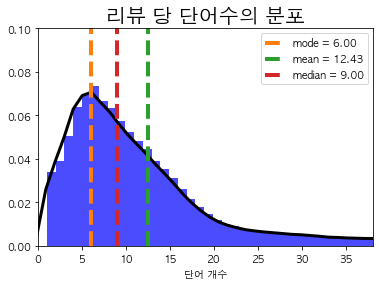

In [39]:
plt.rcParams['font.family'] = 'AppleGothic'   # 한글 깨짐 방지


# 단어수 분포 시각화
fig, ax = plt.subplots()

sns.distplot(wordcounts_train, bins=wordcounts_train.max(),
            hist_kws={"alpha": 0.7, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})

ax.set_xlim(left=0, right=np.percentile(wordcounts_train, 95))
ax.set_xlabel("단어 개수")
ymax = 0.1
plt.ylim(0, ymax)

ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)

ax.set_title('리뷰 당 단어수의 분포', fontsize=20)
plt.legend()
plt.show()

- 5 ~ 10 단어 사이의 리뷰가 가장 많고, 대부분 20개 이하의 단어가 사용된 것을 확인할 수 있다.

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_reviews)

threshold = 4                            # 단어 빈도수 기준
total_cnt = len(tokenizer.word_index)    # 총 단어의 개수
rare_cnt = 0                             # 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                           # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                            # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합의 크기 : {}'.format(total_cnt))
print('등장 빈도가 {}번 이하인 희귀 단어의 수: {}'.format(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율: {:.2f}%".format(rare_cnt / total_cnt * 100))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율: {:.2f}%".format(rare_freq / total_freq * 100))

단어 집합의 크기 : 72655
등장 빈도가 3번 이하인 희귀 단어의 수: 49448
단어 집합에서 희귀 단어의 비율: 68.06%
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.81%


- 전체 단어 집합에서 3회 이하로 사용된 단어가 차지하는 비율이 약 70%나 됨에도 불구하고 상대적인 등장 빈도는 4% 정도 밖에 되지 않는다.
- 앞서 전처리 과정에서 띄어쓰기를 강제로 교정해주는 과정에서 한두개짜리 불용어들이 추가되었을 가능성이 크므로 제거하는 것이 타당할 것 같다.

## 단어 벡터화
---

- 이제 마지막 단계로 위에서 처리해준 리뷰들을 인덱스 벡터로 바꾼 뒤 패딩 처리만 해주면 된다.
- 단어들을 벡터로 임베딩하는 방법은 여러개가 있으나, 단어간의 관계를 잘 표현할 수 있는 word2vec 모델을 사용도록 하자.
- 추가적으로 연속된 3개까지의 단어들의 관계를 고려하기 위해 각 리뷰들에 대해 trigram 을 사용한다.

In [41]:
# word2vec 모델의 하이퍼파라미터 정의
embedding_vector_size = 64     # 임베딩 벡터 사이즈
min_word_count = 3             # 설정된 빈도수 보다 낮은 단어들은 무시
num_workers = 8                # 프로세서 코어 개수
context = 5                    # context window 사이즈 설정 (n-gram 이랑 유사한 개념)
downsampling = 1e-3            # 다운 샘플링 비율. 학습 속도를 높이기 위해 사용되며 주로 0.001이 사용된다.
sg = 0                         # 0 for CBOW, 1 for Skip-gram

In [42]:
# 단어 간 ngram 고려
from gensim.models import Phrases
bigrams = Phrases(sentences = clean_reviews)
trigrams = Phrases(sentences = bigrams[clean_reviews])

In [43]:
# word2vec Skip-gram 모델 정의
from gensim.models import word2vec

print("Training Model...")
model = word2vec.Word2Vec(trigrams[bigrams[clean_reviews]],
                          workers = num_workers,
                          size = embedding_vector_size,
                          min_count = min_word_count,
                          window = context,
                          sample = downsampling,
                          sg = sg)

Training Model...


In [44]:
# 특정 단어와 가장 유사한 단어들 추출
model.wv.most_similar("영화")

[('애니', 0.7810847759246826),
 ('다큐', 0.7302770018577576),
 ('공포영화', 0.7269704341888428),
 ('이렇게', 0.7048866152763367),
 ('애니메이션', 0.7001093626022339),
 ('영화로', 0.6938016414642334),
 ('독립영화', 0.6915158033370972),
 ('만화', 0.6886732578277588),
 ('유실', 0.687038004398346),
 ('영화인', 0.684454619884491)]

In [45]:
# 특정 맥락에 어울리지 않는 단어 파악
model.wv.doesnt_match(["돈", "강아지", "상어", "고양이"])

/Users/dongwook/opt/anaconda3/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'돈'

In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Word2vec 벡터화
def vectorize_data(data, vocab: dict) -> list:
    """
    Word2vec 모델을 이용해 문장을 벡터화 해주는 함수
    """
    print('문장 벡터 변환 중...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = (lambda word: vocab.get(word) is not None)   # word2vec 모델에 학습되지 않은 단어 무시하는 함수
    encode = (lambda review: list(map(keys.index, filter(filter_unknown, review))))  # 벡터화 하는 함수
    vectorized = list(map(encode, data))    # word2vec 벡터 반환
    print('문장 벡터 변환 중... (완료)')
    
    return vectorized



# 단어 벡터 변환 후 패딩 설정
print('ngram 을 사용해서 문장 변환 중...', end='\r')
X_data_train = trigrams[bigrams[clean_reviews]]
print('ngram 을 사용해서 문장 변환 중... (완료)')

input_length = 15      # 패딩 길이 설정

train_inputs = pad_sequences(
    sequences = vectorize_data(X_data_train, vocab = model.wv.vocab),
    maxlen = input_length,
    padding = 'post')
print('각 문장을 벡터로 변환 중... (완료)')

ngram 을 사용해서 문장 변환 중... (완료)
문장 벡터 변환 중... (완료)
각 문장을 벡터로 변환 중... (완료)


- 약 2~3분 정도 소요된다.

In [47]:
print(train_inputs.shape)
train_inputs  # 학습 리뷰 데이터

(148523, 15)


array([[    0,     1,     2, ...,     0,     0,     0],
       [    4,     5,     6, ...,     0,     0,     0],
       [   12,    13,    14, ...,     0,     0,     0],
       ...,
       [   65,   150,  7820, ...,     0,     0,     0],
       [ 1253,     7, 13334, ...,     0,     0,     0],
       [  617,     7, 19189, ...,     0,     0,     0]], dtype=int32)

In [48]:
# 테스트 데이터 벡터화

# 단어 벡터 변환 후 패딩 설정
print('ngram 을 사용해서 문장 변환 중...', end='\r')
X_data_test = trigrams[bigrams[clean_reviews_test]]
print('ngram 을 사용해서 문장 변환 중... (완료)')

input_length = 15      # 패딩 길이 설정

test_inputs = pad_sequences(
    sequences = vectorize_data(X_data_test, vocab = model.wv.vocab),
    maxlen = input_length,
    padding = 'post')
print('각 문장을 벡터로 변환 중... (완료)')

ngram 을 사용해서 문장 변환 중... (완료)
문장 벡터 변환 중... (완료)
각 문장을 벡터로 변환 중... (완료)


In [49]:
print(test_inputs.shape)
test_inputs  # 테스트 리뷰 데이터

(49485, 15)


array([[11934,     0,     0, ...,     0,     0,     0],
       [   88,   113,   171, ...,     0,     0,     0],
       [22184,  6523, 22618, ...,     0,     0,     0],
       ...,
       [ 5490,  1850, 11843, ...,     0,     0,     0],
       [  195, 11044, 13710, ..., 16272,     0,     0],
       [ 7602,    24,    87, ...,     0,     0,     0]], dtype=int32)

# 데이터 저장

전처리가 완료된 데이터들을 추후에 사용하기 위해 별도로 저장해두자.

In [50]:
np.save(open("./Preprocessed/train_input_embedded.npy", "wb"), train_inputs)
np.save(open("./Preprocessed/test_input_embedded.npy", "wb"), test_inputs)
np.save(open("./Preprocessed/word2vec_weights.npy", "wb"), model.wv.vectors)

train_data.to_csv("./Preprocessed/train_data_preprocessed.csv", index=False)
test_data.to_csv("./Preprocessed/test_data_preprocessed.csv", index=False)

In [51]:
np.load(open("./Preprocessed/word2vec_weights.npy", "rb"))

array([[-2.1131377e+00,  1.8393431e+00,  5.8106536e-01, ...,
         1.1477711e+00,  1.4246622e+00, -1.6565651e-01],
       [ 1.2079192e+00, -2.1508222e+00,  1.9984616e+00, ...,
         2.3822107e+00, -8.0653381e-01,  1.1349719e+00],
       [ 2.4079895e+00, -2.2747638e+00,  9.1027725e-01, ...,
         4.4114643e-01,  1.0521927e+00, -1.3157986e+00],
       ...,
       [ 1.3476901e-02,  2.2586703e-02,  1.0158729e-02, ...,
        -8.5456809e-03,  4.1596118e-02,  1.5040760e-02],
       [ 2.4638060e-02, -3.7844166e-02, -1.2605416e-02, ...,
         2.8696607e-03, -1.4675030e-02, -1.1668139e-02],
       [ 2.8592119e-02, -4.3789584e-02, -2.6703516e-02, ...,
        -3.1783011e-02,  7.2704977e-03,  1.1685374e-03]], dtype=float32)

In [52]:
model.wv.vectors

array([[-2.1131377e+00,  1.8393431e+00,  5.8106536e-01, ...,
         1.1477711e+00,  1.4246622e+00, -1.6565651e-01],
       [ 1.2079192e+00, -2.1508222e+00,  1.9984616e+00, ...,
         2.3822107e+00, -8.0653381e-01,  1.1349719e+00],
       [ 2.4079895e+00, -2.2747638e+00,  9.1027725e-01, ...,
         4.4114643e-01,  1.0521927e+00, -1.3157986e+00],
       ...,
       [ 1.3476901e-02,  2.2586703e-02,  1.0158729e-02, ...,
        -8.5456809e-03,  4.1596118e-02,  1.5040760e-02],
       [ 2.4638060e-02, -3.7844166e-02, -1.2605416e-02, ...,
         2.8696607e-03, -1.4675030e-02, -1.1668139e-02],
       [ 2.8592119e-02, -4.3789584e-02, -2.6703516e-02, ...,
        -3.1783011e-02,  7.2704977e-03,  1.1685374e-03]], dtype=float32)

In [53]:
model.wv.vectors.shape

(39715, 64)

In [54]:
test_inputs

array([[11934,     0,     0, ...,     0,     0,     0],
       [   88,   113,   171, ...,     0,     0,     0],
       [22184,  6523, 22618, ...,     0,     0,     0],
       ...,
       [ 5490,  1850, 11843, ...,     0,     0,     0],
       [  195, 11044, 13710, ..., 16272,     0,     0],
       [ 7602,    24,    87, ...,     0,     0,     0]], dtype=int32)